In [219]:
import pandas as pd
import numpy as np
# import scipy as sp
# from datetime import datetime
from dateutil import parser
from matplotlib import pyplot as plt


### Clusters of interest  
E-128 nodes, IDs: 9,10,11  
F-256 nodes, IDs: 14,15,16,17

In [220]:
E_IDs = [9, 10, 11]
F_IDs = [14,15,16,17]

In [221]:
# Read LANL data
lanl = pd.read_csv("data/LANL.csv")
lanl.head()

,System,machine type,nodes,procstot,procsinnode,nodenum,nodenumz,node install,node prod,node decom,...,Prob Started (mm/dd/yy hh:mm),Prob Fixed (mm/dd/yy hh:mm),Down Time,Facilities,Hardware,Human Error,Network,Undetermined,Software,Same Event
0,2,cluster,49.0,6152.0,80.0,0.0,0.0,5-Apr,5-Jun,current,...,6/21/2005 10:54,6/21/2005 11:00,6,NaN,Graphics Accel Hdwr,NaN,NaN,NaN,NaN,No
1,2,cluster,49.0,6152.0,80.0,0.0,0.0,5-Apr,5-Jun,current,...,9/6/2005 9:13,9/6/2005 9:19,6,NaN,NaN,NaN,NaN,NaN,Other Software,No
2,2,cluster,49.0,6152.0,80.0,0.0,0.0,5-Apr,5-Jun,current,...,9/6/2005 10:32,9/6/2005 10:46,14,NaN,NaN,NaN,NaN,Undetermined,NaN,No
3,2,cluster,49.0,6152.0,80.0,0.0,0.0,5-Apr,5-Jun,current,...,9/6/2005 14:50,9/6/2005 15:08,18,NaN,NaN,NaN,NaN,NaN,Other Software,No
4,2,cluster,49.0,6152.0,80.0,0.0,0.0,5-Apr,5-Jun,current,...,9/8/2005 16:52,9/8/2005 16:57,5,NaN,NaN,NaN,NaN,Undetermined,NaN,No


In [222]:
lanl.describe()

,System,nodes,procstot,procsinnode,nodenum,nodenumz,mem,cputype,memtype,num intercon,Down Time
count,23739.000000,23613.000000,23613.000000,23613.000000,23613.000000,23613.000000,23613.00000,23613.000000,23613.000000,23613.000000,23739.000000
mean,12.316020,412.039809,3637.940118,58.041672,328.775590,186.204506,27.35599,2.036929,2.036929,5.117732,352.381440
std,7.728558,434.469638,2069.976059,61.866268,534.668188,274.941531,54.55763,1.721330,1.721330,4.591858,4683.012911
min,2.000000,1.000000,4.000000,2.000000,0.000000,0.000000,1.00000,1.000000,1.000000,0.000000,0.000000
25%,2.000000,49.000000,2048.000000,4.000000,9.000000,8.000000,8.00000,1.000000,1.000000,2.000000,25.000000
50%,16.000000,128.000000,4096.000000,4.000000,40.000000,37.000000,16.00000,2.000000,2.000000,2.000000,59.000000
75%,19.000000,1024.000000,6152.000000,128.000000,384.000000,241.000000,32.00000,2.000000,2.000000,12.000000,144.000000
max,24.000000,1024.000000,6152.000000,256.000000,2047.000000,1023.000000,1024.00000,8.000000,8.000000,12.000000,319482.000000


In [223]:
# Drop useless columns
for col in lanl:
    if len(lanl[col].unique()) == 1:
        print("Dropping: ", str(col))
        del lanl[col]
        

Dropping:  Same Event


In [224]:
# look at the different possibilities in each column
for col in lanl:
    print(col, ": ", lanl[col].unique())

System :  [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
machine type :  ['cluster' 'smp' 'numa' nan]
nodes :  [4.900e+01 1.280e+02 3.200e+01 1.000e+00 1.640e+02 2.560e+02 5.120e+02
 1.600e+01       nan 1.024e+03 5.000e+00]
procstot :  [6.152e+03 5.120e+02 1.280e+02 8.000e+00 3.280e+02 1.024e+03 2.560e+02
 2.048e+03       nan 4.096e+03 4.000e+00 5.440e+02 3.200e+01]
procsinnode :  [ 80. 128.   4.   8.   2. 256.  nan  32.]
nodenum :  [  0.   1.   2. ... 436. 442. 447.]
nodenumz :  [0.00e+00 1.00e+00 2.00e+00 ... 9.94e+02 1.00e+03 1.02e+03]
node install :  ['5-Apr' 'Nov-96' '3-Aug' 'before tracking' '1-Mar' '2-Dec' '5-Mar'
 '4-Nov' 'Oct-96' nan '2-Mar' '2-Aug' '1-Oct' '1-Aug' 'Jan-98' 'Oct-98'
 '2-Nov']
node prod :  ['5-Jun' 'Jan-97' '3-Sep' 'before tracking' '1-Apr' '2-Dec' '5-Mar'
 '4-Nov' 'Dec-96' nan '2-May' '2-Oct' '1-Dec' '1-Sep' 'Jan-98' 'Oct-98'
 '2-Nov']
node decom :  ['current' '5-Nov' 'Dec-99' '5-Jun' '2-Sep' nan '2-Jan' '3-Apr' '4-Dec'
 '3-Dec']
fru ty

In [225]:
# cluster E with 128 nodes
E = lanl.loc[lanl["System"] == 9]
E_temp = lanl.loc[lanl["System"] == 10]
E.append(E_temp)
E_temp = lanl.loc[lanl["System"] == 11]
E.append(E_temp)
E.describe()

,System,nodes,procstot,procsinnode,nodenum,nodenumz,mem,cputype,memtype,num intercon,Down Time
count,280.0,280.0,280.0,280.0,280.000000,280.000000,280.0,280.0,280.0,280.0,280.000000
mean,9.0,256.0,512.0,2.0,113.150000,113.150000,4.0,8.0,8.0,1.0,1039.157143
std,0.0,0.0,0.0,0.0,73.045714,73.045714,0.0,0.0,0.0,0.0,8922.923477
min,9.0,256.0,512.0,2.0,0.000000,0.000000,4.0,8.0,8.0,1.0,0.000000
25%,9.0,256.0,512.0,2.0,63.750000,63.750000,4.0,8.0,8.0,1.0,1.000000
50%,9.0,256.0,512.0,2.0,100.000000,100.000000,4.0,8.0,8.0,1.0,10.000000
75%,9.0,256.0,512.0,2.0,162.750000,162.750000,4.0,8.0,8.0,1.0,86.500000
max,9.0,256.0,512.0,2.0,255.000000,255.000000,4.0,8.0,8.0,1.0,139845.000000


In [226]:
# cluster F with 256 nodes
F = lanl.loc[lanl["System"] == 14]
F_temp = lanl.loc[lanl["System"] == 15]
F.append(F_temp)
F_temp = lanl.loc[lanl["System"] == 16]
F.append(F_temp)
F_temp = lanl.loc[lanl["System"] == 17]
F.append(F_temp)
# F.head()
F.describe()

,System,nodes,procstot,procsinnode,nodenum,nodenumz,mem,cputype,memtype,num intercon,Down Time
count,125.0,125.0,125.0,125.0,125.000000,125.000000,125.0,125.0,125.0,125.0,125.000000
mean,14.0,128.0,256.0,2.0,179.216000,179.216000,4.0,8.0,8.0,1.0,5911.256000
std,0.0,0.0,0.0,0.0,41.018797,41.018797,0.0,0.0,0.0,0.0,32485.105039
min,14.0,128.0,256.0,2.0,129.000000,129.000000,4.0,8.0,8.0,1.0,0.000000
25%,14.0,128.0,256.0,2.0,138.000000,138.000000,4.0,8.0,8.0,1.0,2.000000
50%,14.0,128.0,256.0,2.0,174.000000,174.000000,4.0,8.0,8.0,1.0,15.000000
75%,14.0,128.0,256.0,2.0,208.000000,208.000000,4.0,8.0,8.0,1.0,618.000000
max,14.0,128.0,256.0,2.0,255.000000,255.000000,4.0,8.0,8.0,1.0,255840.000000


In [237]:
# get data for smarter plots
date_sort = lanl.sort_values("Prob Started (mm/dd/yy hh:mm)")

first_issue = parser.parse(date_sort["Prob Started (mm/dd/yy hh:mm)"].min())
last_issue = parser.parse(date_sort["Prob Fixed (mm/dd/yy hh:mm)"].max())

print("First Time: ", first_issue)
print("Last Time: ", last_issue)
time_difference = last_issue - first_issue
interval_size = int(time_difference.total_seconds()/60)

print("Minutes: ", interval_size)

plt.close('all')

graph_data = {}
for ID in date_sort["System"].unique():
    graph_data[ID] = np.zeros(interval_size)

First Time:  1998-01-01 10:28:00
Last Time:  2005-09-09 09:51:00
Minutes:  4043483


In [ ]:
# fig, ax = plt.subplots()
# ax.plot(r.date, r.adj_close)

# # format the ticks
# ax.xaxis.set_major_locator(years)
# ax.xaxis.set_major_formatter(yearsFmt)
# ax.xaxis.set_minor_locator(months)

# # round to nearest years...
# datemin = np.datetime64(r.date[0], 'Y')
# datemax = np.datetime64(r.date[-1], 'Y') + np.timedelta64(1, 'Y')
# ax.set_xlim(datemin, datemax)

In [211]:
# setup lists to graph by Minute
for index, row in date_sort.iterrows():
    issue_start_time = int((parser.parse(row["Prob Started (mm/dd/yy hh:mm)"]) - first_issue).total_seconds()/60)
    issue_end_time = int((parser.parse(row["Prob Fixed (mm/dd/yy hh:mm)"]) - first_issue).total_seconds()/60)
    issue_end_time = min(issue_end_time, interval_size)
    i = issue_start_time
    while i < issue_end_time:
        graph_data[row["System"]][i] += 1
        i += 1

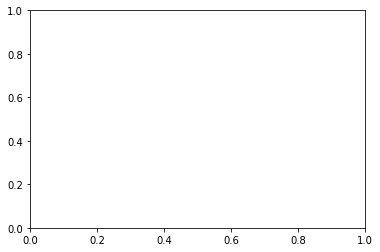

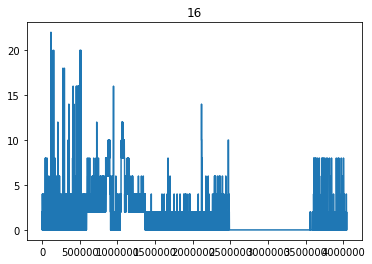

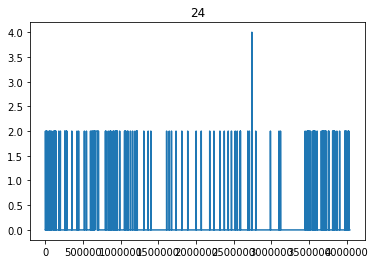

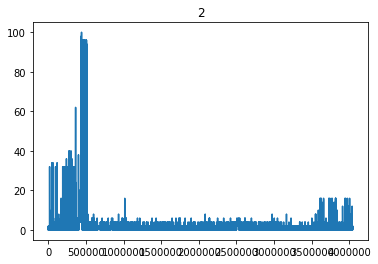

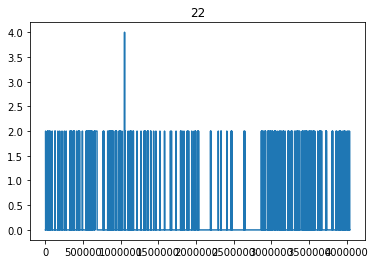

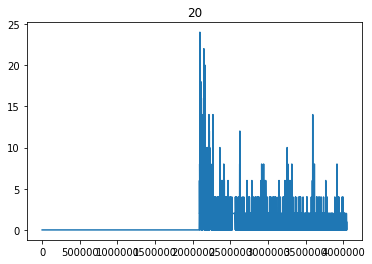

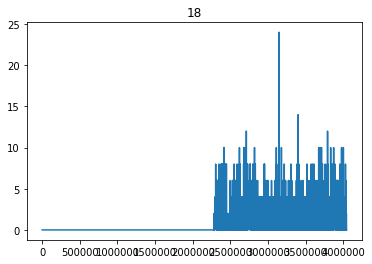

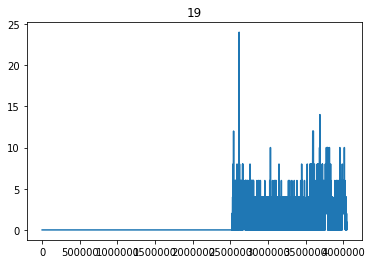

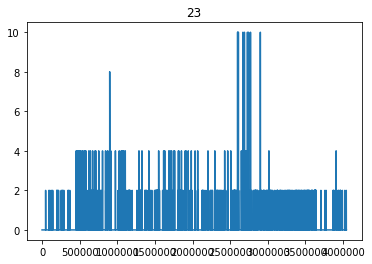

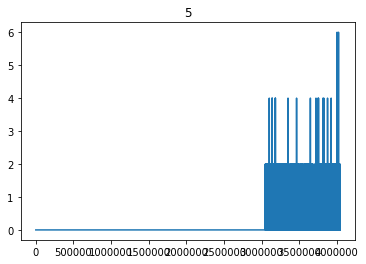

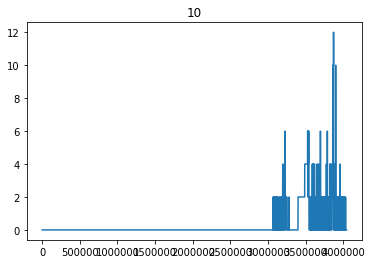

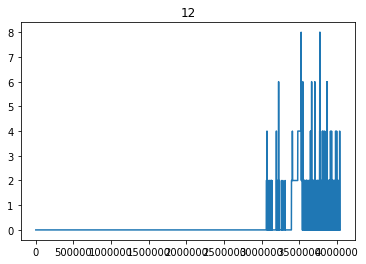

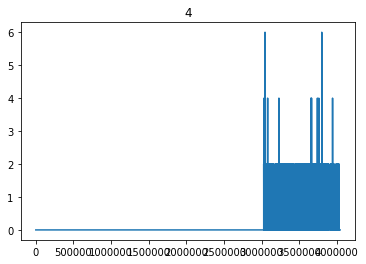

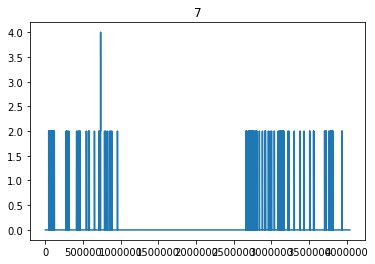

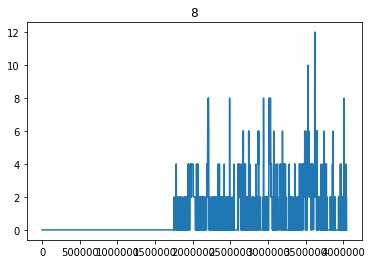

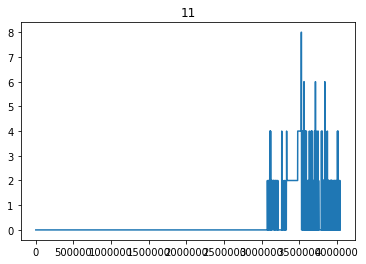

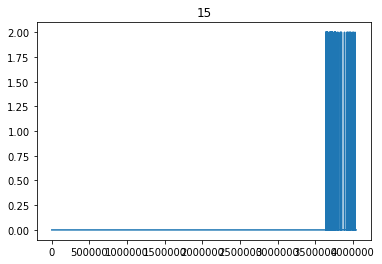

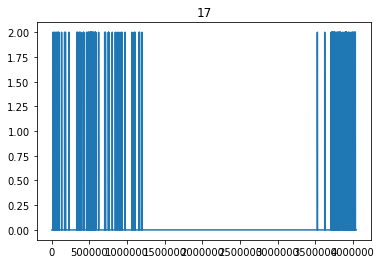

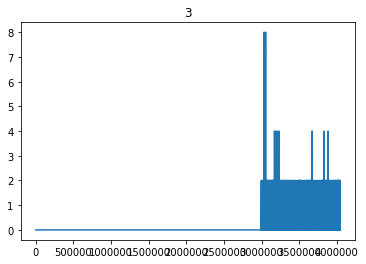

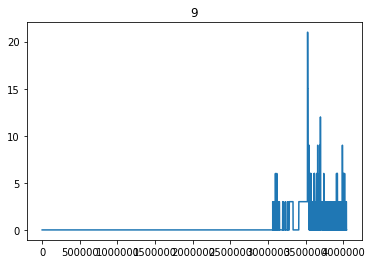

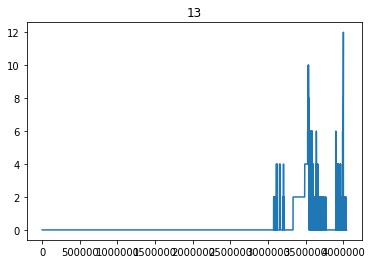

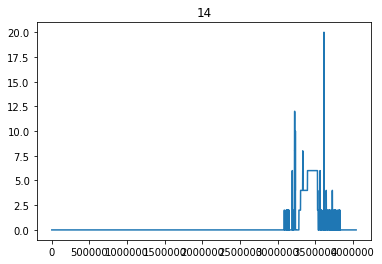

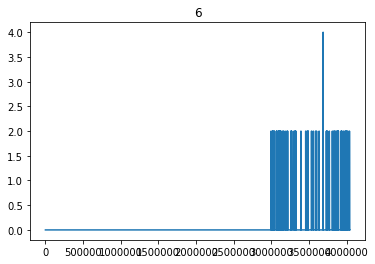

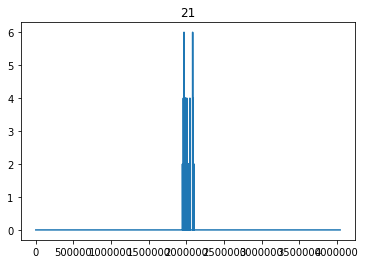

In [212]:
# graph the lists
for key in graph_data:
    fig, ax = plt.subplots()
    ax.plot(range(0,interval_size), graph_data[key])
    ax.set_title(key)
    plt.show()
# fig, ax = plt.subplots()
# ax.plot(range(0,interval_size), graph_data[9])
# plt.show()

Threshold:  469.8419197663479
Outliers:  1599  ~ 0.06735751295336788 %


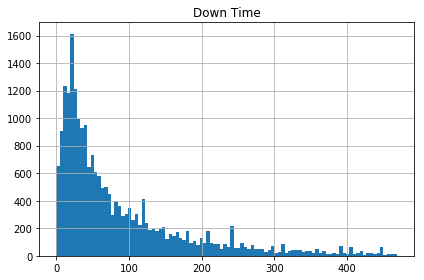

In [242]:
# Plot Down Times
plt.close('all')
# fig, ax = plt.subplots()

down_time_mean = date_sort["Down Time"].mean()
down_time_std = date_sort["Down Time"].std()
down_time_count = date_sort["Down Time"].count()
threshold = down_time_mean+down_time_mean/3#+(down_time_std*1/1000)
# threshold = 100
outliers = len(date_sort.loc[date_sort["Down Time"] > threshold])
print("Threshold: ", threshold)
print("Outliers: ", outliers, " ~", (outliers/down_time_count), "%")

down_time_clean = date_sort.loc[date_sort["Down Time"] <= threshold]
down_time_clean.hist(column="Down Time", bins=100)

plt.tight_layout()
plt.show()